In [1]:
using QuickPOMDPs
using POMDPs
using POMDPTools
using Distributions
using LinearAlgebra
using MCTS
using POMDPSimulators
using POMDPPolicies
#using POMDPTutorials
using POMDPModels
using POMDPModelTools
using Plots
using CSV
using Tables

### Define problem

*** Parameters

In [2]:
# Dimensions
max_progress = 5
max_power = 50
max_h2o = 50
max_o2 = 50
max_food = 50

# Uncertainties
p_mission_regression = 0.05
p_power_fail = 0.02
p_water_loss = 0.02
p_food_loss = 0.02
p_no_mission_progress = 0.05

# Resource consumption
consumed_power = -2 # generated
consumed_h2o = 1
consumed_o2 = 1
consumed_food = 1

1

In [3]:
# Define all possible states and actions (with constraints)
# [progress, power, h2o, o2, food]
indexed = LinearIndices((max_progress, max_power, max_h2o, max_o2, max_food))
states = 1:indexed[max_progress, max_power, max_h2o, max_o2, max_food]

basic_actions = [
      CartesianIndex(1, -3, 0, 0, 0), # make mission progress
      CartesianIndex(0, -2, 5, 0, 0), # make water 
      CartesianIndex(0, -2, -1, 5, 0), # make oxygen
      CartesianIndex(0, -2, -1, -1, 5), # make food
      CartesianIndex(0, 0, 0, 0, 0)
] # do nothing
consumed = CartesianIndex(0, consumed_power, consumed_h2o, consumed_o2, consumed_food)
actions = [action - consumed for action in basic_actions]

5-element Vector{CartesianIndex{5}}:
 CartesianIndex(1, -1, -1, -1, -1)
 CartesianIndex(0, 0, 4, -1, -1)
 CartesianIndex(0, 0, -2, 4, -1)
 CartesianIndex(0, 0, -2, -2, 4)
 CartesianIndex(0, 2, -1, -1, -1)

### Reward, Transition

In [4]:
# Determine if action is out of bounds
# Associated consequences are reflected in transition/reward functions
state_maxes = [max_progress, max_power, max_h2o, max_o2, max_food]

function outofbounds(state, action)
    for i in 1:length(state)
        if ((state[i] + action[i]) < 1 || (state[i] + action[i]) > state_maxes[i])
            return true
        end
    end
    return false
end

# Determine if action is out of bounds
# Associated consequences are reflected in transition/reward functions
state_maxes = [max_progress, max_power, max_h2o, max_o2, max_food]
function clamp_state(state)
    for i in 1:length(state)
        state[i] = clamp(state[i], 1, state_maxes[i])
    end
    return state
end

clamp_state (generic function with 1 method)

In [5]:
function reward(s, a)
    svec = CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s]
    if svec[1] == max_progress
        r = 1000
    elseif outofbounds(svec, a) # If invalid action
        r = -1000000
    else
        r = -1
    end
    return r
end
#end    

reward (generic function with 1 method)

In [23]:
     #thought: when we make no mission progress or lose water - we would still consume/produce energy??

# Transition function
function transition(s, a)
    p_nominal = 1 - p_no_mission_progress - p_water_loss - p_power_fail - p_mission_regression 
    probabilities = [p_no_mission_progress, p_water_loss, p_power_fail, p_mission_regression, p_nominal]

    svec = CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s]
    svec = collect(Tuple(svec))
    a = collect(Tuple(a))

    if outofbounds(svec, a)
        return s
    else
        spvec_no_mission_progress = svec

        spvec_water_loss = svec + a
        spvec_water_loss[3] = 1 # lose all water

        spvec_power_fail = svec + a
        spvec_power_fail[2] = 1 # lose all energy

        spvec_mission_regression = svec + a
        spvec_mission_regression[1] = spvec_mission_regression[1] - 1 # mission setback

        spvec_nominal = svec + a

        spvec = [spvec_no_mission_progress, spvec_water_loss, spvec_power_fail, spvec_mission_regression, spvec_nominal]
    end
    
    desired_length = length(spvec)
    cart_spvec = [CartesianIndex(1,1,1,1,1) for _ in 1:desired_length]
    sp = []
    for i in 1:length(probabilities)
        spvec[i] = clamp_state(spvec[i])
        cart_spvec[i] = CartesianIndex(Tuple(spvec[i]))

        push!(sp, indexed[CartesianIndex(Tuple(spvec[i]))])
    end

    return  rand(SparseCat(sp, probabilities))
end


transition (generic function with 1 method)

*** Simulate

In [24]:
struct setup_struct
    initial_state::Int
    policy::Int
end

In [25]:
#generate different setups to generate data
possible_initials = [indexed[1, 20, 20, 20, 20], indexed[4, 20, 20, 20, 20], indexed[2, 10, 10, 10, 10], indexed[1, 1, 1, 1, 1], indexed[3, 10, 1, 10, 1]]
possible_actions = [0, 1, 2, 3, 4 ,5]

setups = []
for i in 1:length(possible_actions)
    for j in 1:length(possible_initials)
        push!(setups, setup_struct(possible_initials[j], possible_actions[i]))
    end
end


In [26]:
#simulate
#initialize
sarsp = Imatrix = zeros(Int, 4, 1)

for i in 1:length(setups)
    setup = setups[i]
    current_state = setup.initial_state #initialstate(mission)
    policy = setup.policy

    if (policy == 0)
        random_policy = true
    else
        random_policy = false
    end
    # s a r s'
    count = 0
    while (CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[current_state][1] != state_maxes[1] && count < 10)
        if (random_policy)
            policy = rand(1:5) 
        end 
        a = actions[policy] 
        
        next_state = transition(current_state, a)
        r = reward(next_state, a)
        sarsp = hcat(sarsp, [current_state, policy, r, next_state])
        if (next_state == current_state)
            count += 1
        end
        current_state = next_state
    end
end

#delete first row again
sarsp = sarsp[:, 2:end]




11541846

10905346

10329846

9692106

9054352

11528852

10891112

10315612

9740112

9102358

8526858

7890358

7252618

9727118

9089364

8451624

8451624

7813870

12117349

11541849

10904095

5164297

5164297

7638796

7001042

6364542

5726788

8201288

8201288

7625788

6987538

6987538

6987538

6987538

6351038

5714538

5078037

4440252

3802512

3164758

2527017

5001517

5001517

5001517

5001517

4426017

3788263

6262763

5626263

5626263

5050763

4413009

3776509

6251009

5675509

8150009

8150009

1

1

1

1

1

1

1

1

1

1

112548

112548

112548

112548

112548

112548

112548

112548

112548

112548

11479592

10837588

10837588

10837588

10837588

10837588

10837588

10837588

10837588

10837588

10837588

10837588

12117349

11479595

5102043

4464289

3826535

1

1

1

1

1

1

1

1

1

1

112548

112548

112548

112548

112548

112548

112548

112548

112548

112548

11480846

10844346

10207846

9571346

8934846

8298346

7661846

7661846

7661846

7661846

7661846

7661846

7661846

7661846

7661846

7661846

7661846

11480849

10844349

10207849

10207849

9571349

8934849

8298349

7661848

7661848

7661848

7661848

7661848

7661848

7661848

7661848

7661848

7661848

5103297

4466797

3830297

3193797

2557297

1920796

1284296

647796

11296

11296

11296

11296

11296

11296

11296

11296

11296

11296

11296

1

1

1

1

1

1

1

1

1

1

112548

112548

112548

112548

112548

112548

112548

112548

112548

112548

11541846

10966346

10390846

9815346

9237596

9237596

9237596

9237596

9237596

9237596

9237596

9237596

9237596

9237596

9237596

11541849

10966349

10390849

9815349

9239849

8664349

8088849

8088849

8088849

8088849

8088849

8088849

8088849

8088849

8088849

8088849

8088849

5164296

4588796

4013296

3437796

3437796

3437796

3437796

3437796

3437796

3437796

3437796

3437796

3437796

3437796

1

1

1

1

1

1

1

1

1

1

112548

112548

112548

112548

112548

112548

112548

112548

112548

112548

14591846

17066346

19540846

22015346

24489846

26964346

29438846

29438846

29438846

29438846

29438846

29438846

29438846

29438846

29438846

29438846

29438846

14591849

17066349

17066349

19540849

22015349

24489849

26964349

29438849

29438849

29438849

29438849

29438849

29438849

29438849

29438849

29438849

29438849

8214297

10688797

13163297

15637797

15637797

15637797

15637797

15637797

15637797

15637797

15637797

15637797

15637797

15637797

1

1

1

1

1

1

1

1

1

1

112548

112548

112548

112548

112548

112548

112548

112548

112548

112548

11479606

10841866

10841866

10204126

9566386

8928646

8290906

7653166

7015426

6377686

5739946

5102206

4464466

3826726

3188986

2551246

2551246

2551246

2551246

2551246

2551246

2551246

2551246

2551246

2551246

11479609

10841869

10204129

9566389

8928649

8290909

7653169

7015429

6377689

5739949

5102209

4462719

4462719

4462719

4462719

4462719

4462719

4462719

4462719

4462719

4462719

4462719

5102057

4464317

3826577

3826577

3187587

3187587

3187587

3187587

3187587

3187587

3187587

3187587

3187587

3187587

1

1

1

1

1

1

1

1

1

1

112548

112548

112548

112548

112548

112548

112548

112548

112548

112548

4×402 Matrix{Int64}:
 12117346  11541846  10905346  10329846  …    112548    112548    112548
        3         2         3         5            5         5         5
       -1        -1        -1        -1     -1000000  -1000000  -1000000
 11541846  10905346  10329846   9692106       112548    112548    112548

In [27]:
#write to csv

# Specify the filename
filename = "data.csv"

# Write the matrix to the CSV file
CSV.write(filename, Tables.table(sarsp'), header = ["s", "a", "r", "s'"])

"data.csv"

In [11]:
#prepare to plot

mission = states[3,:]
resources_E = states[1, :]
resources_H2O = states[2,:]
resources_total = resources_E  + resources_H2O
goal = fill(mission[end], length(mission))
t = range(0, length=length(mission))
rewards_accumulation = cumsum(rewards)


UndefVarError: UndefVarError: `rewards` not defined

In [12]:
#plot Mission Progress over Resources
p1 = plot()
plot!(p1, mission, resources_total, marker=(:circle,5), arrow=true, arrowsize=0.1, legend=false)
vline!(p1, goal[1])
ylabel!("Resources")
xlabel!("Mission Progress")
ylims!(0.9, (state_dimensions[1] + state_dimensions[2] + 1))
xlims!(0.9, state_dimensions[3] + 0.5)

#savefig(p1, "Mission Progress VS Resources.pdf")

UndefVarError: UndefVarError: `state_dimensions` not defined

┌ Info: Saved animation to /var/folders/53/dkwtw9r94vvbm2k2b5khb0ch0000gn/T/jl_7EXW3GhypE.gif
└ @ Plots /Users/Anna/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/var/folders/53/dkwtw9r94vvbm2k2b5khb0ch0000gn/T/jl_7EXW3GhypE.gif")
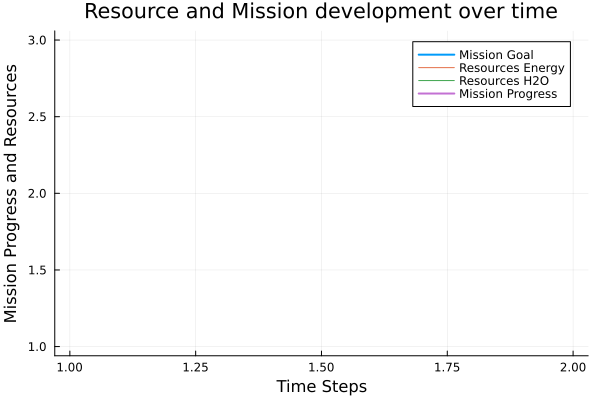

In [13]:
#plot Mission and Resource development over time
#savefig(p2, "Mission Progress VS Resources.pdf")
anim = @animate for i in 1:length(mission)
    p2 = plot()
    plot!(p2 , 1:i, goal[1:i],  linewidth=2,   label="Mission Goal")
    plot!(p2 ,1:i, [resources_E[1:i], resources_H2O[1:i]], label=["Resources Energy" "Resources H2O"], title = "Resource and Mission development over time")
    plot!(p2 ,1:i, mission[1:i], linewidth = 2,  label="Mission Progress")
    xlabel!("Time Steps")
    ylabel!("Mission Progress and Resources")
end


gif(anim, fps=5)

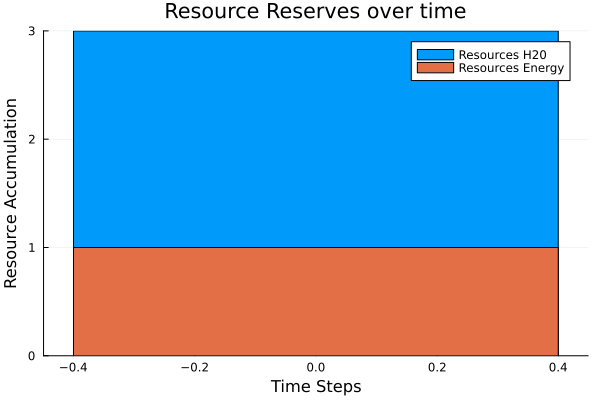

In [14]:
#Resource level histogram
p3 = bar(t, [resources_total, resources_E], xlabel="Time Steps", ylabel="Resource Accumulation", label=["Resources H20" "Resources Energy"], title = "Resource Reserves over time")

#savefig(p3, "Resource Reserves.pdf")

In [15]:
#Plot Reward accumulation over time
layout = @layout [a b] #creates 1x2 subplots

p4 = plot(t[1:end-1], rewards[1:end-1], subplot=1, layout=layout,legend=false)
plot!(p4, t, rewards_accumulation, subplot=2, legend=false)
xlabel!(p4, "Time Steps")
ylabel!(p4, "Rewards", subplot=1)
ylabel!(p4, "Accumulated Rewards", subplot=2)
title!(p4,"Rewards (except the \n last time step)", subplot = 1)
title!(p4,"Accumulated Rewards", subplot = 2)

#savefig(p4, "Rewards.pdf")

UndefVarError: UndefVarError: `rewards` not defined